## Dataset

This project uses the "Blood Cell Images Dataset" by Paul Mooney.

Download from:
https://www.kaggle.com/datasets/paultimothymooney/blood-cells

After downloading, upload and unzip the dataset in Google Colab before running.


In [13]:
!unzip -o blood-cells.zip


Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

Classes: ['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
Total Images Found: 9957

Processing Images...

Processing Completed ✅

========== BOUNDARY ACCURACY ==========

K-Means Average : 0.04821197509765625
FCM Average     : 0.04868499755859375



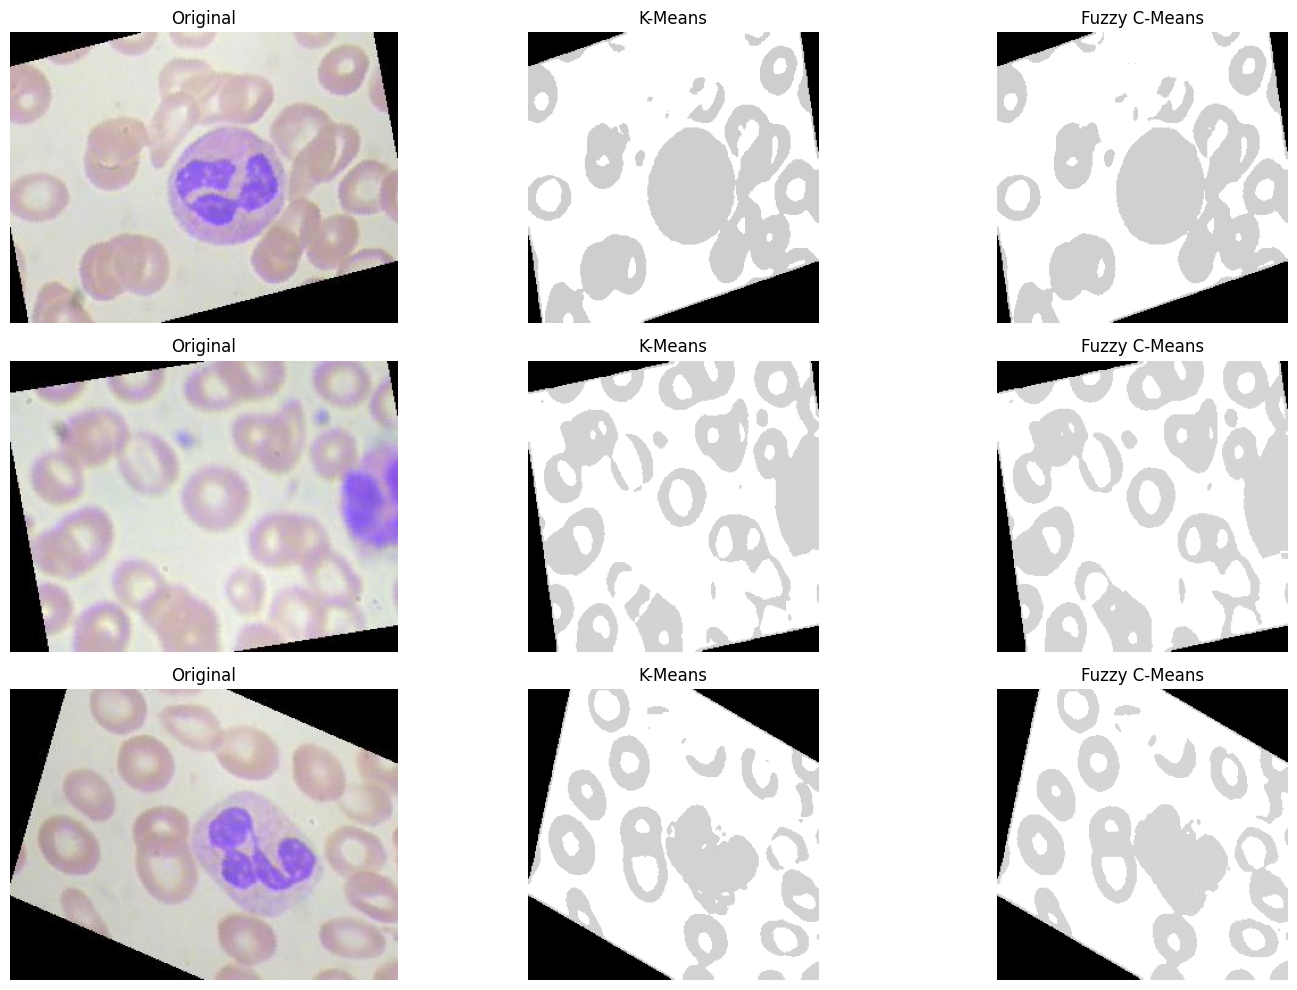

In [14]:
# ==========================================
# DLMI PROJECT 2
# WBC Segmentation: K-Means vs Fuzzy C-Means
# ==========================================

# Install libraries
!pip install -q opencv-python scikit-image scikit-fuzzy scikit-learn matplotlib numpy


# -------------------------------
# Imports
# -------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz


# -------------------------------
# Dataset Path
# -------------------------------
DATA_PATH = "dataset2-master/dataset2-master/images/TRAIN"

print("Classes:", os.listdir(DATA_PATH))


# -------------------------------
# Collect All Image Paths
# -------------------------------
image_paths = []

for cls in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, cls)

    for img_name in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img_name))

print("Total Images Found:", len(image_paths))


# -------------------------------
# Preprocessing
# -------------------------------
def preprocess(img):

    img = cv2.resize(img, (256,256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    return blur


# -------------------------------
# K-Means Segmentation
# -------------------------------
def kmeans_seg(img, k=3):

    Z = img.reshape((-1,1))
    Z = np.float32(Z)

    criteria = (
        cv2.TERM_CRITERIA_EPS +
        cv2.TERM_CRITERIA_MAX_ITER,
        10,
        1.0
    )

    _, label, center = cv2.kmeans(
        Z,
        k,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    center = np.uint8(center)

    res = center[label.flatten()]
    segmented = res.reshape(img.shape)

    return segmented


# -------------------------------
# Fuzzy C-Means Segmentation
# -------------------------------
def fcm_seg(img, c=3):

    data = img.flatten().astype(np.float64)

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data.reshape(1,-1),
        c,
        2,
        error=0.005,
        maxiter=1000
    )

    cluster = np.argmax(u, axis=0)

    segmented = cntr[cluster].reshape(img.shape)

    return segmented.astype(np.uint8)


# -------------------------------
# Boundary Accuracy (Edge Based)
# -------------------------------
def boundary_score(seg):

    edges = cv2.Canny(seg, 50, 150)

    return np.sum(edges > 0) / edges.size


# -------------------------------
# Run Experiment (Sample = 50)
# -------------------------------
print("\nProcessing Images...\n")

kmeans_results = []
fcm_results = []

k_scores = []
f_scores = []

SAMPLE_SIZE = 50

for path in image_paths[:SAMPLE_SIZE]:

    img = cv2.imread(path)

    if img is None:
        continue

    pre = preprocess(img)

    km = kmeans_seg(pre)
    fcm = fcm_seg(pre)

    kmeans_results.append(km)
    fcm_results.append(fcm)

    k_scores.append(boundary_score(km))
    f_scores.append(boundary_score(fcm))


print("Processing Completed ✅")


# -------------------------------
# Print Results
# -------------------------------
print("\n========== BOUNDARY ACCURACY ==========\n")

print("K-Means Average :", np.mean(k_scores))
print("FCM Average     :", np.mean(f_scores))

print("\n=======================================")


# -------------------------------
# Visualization (3 Samples)
# -------------------------------
plt.figure(figsize=(15,10))

for i, path in enumerate(image_paths[:3]):

    img = cv2.imread(path)

    pre = preprocess(img)

    km = kmeans_seg(pre)
    fcm = fcm_seg(pre)

    plt.subplot(3,3,i*3+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(3,3,i*3+2)
    plt.imshow(km, cmap="gray")
    plt.title("K-Means")
    plt.axis("off")

    plt.subplot(3,3,i*3+3)
    plt.imshow(fcm, cmap="gray")
    plt.title("Fuzzy C-Means")
    plt.axis("off")


plt.tight_layout()
plt.show()
